In [1]:
import os
import sys
import numpy as np
import traci
from keras import models, layers, optimizers
from collections import deque

C:\Users\Eugenio\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### halting 

In [2]:
def TL_state(detectors_ID):	
    state_list = []		
    for detector in detectors_ID:
        speed = traci.lanearea.getLastStepMeanSpeed(detector)
        # Returns the mean speed of vehicles that were 
        # on the named induction loop within the last simulation step [m/s]
        state_list.append(speed)

        n_veh = traci.lanearea.getLastStepVehicleNumber(detector)
        # Returns the number of vehicles that were 
        # on the named induction loop within the last simulation step [m/s]
        state_list.append(n_veh)

    state_list.append(traci.trafficlight.getPhase(traci.trafficlight.getIDList()[0]))
    state = np.reshape(state_list, [1, 17])
    return state

In [3]:
def TL_reward(detectors_ID):
    #delay = []
    halting = []
    for detector in detectors_ID:
        halting.append(-traci.lanearea.getLastStepHaltingNumber(detector))
    return sum(halting)

In [4]:
class AgentClass(object):
    """docstring for agent"""
    def __init__(self,exploration):
        self.actions_list = [0,1]
        self.training_memory = deque(maxlen=10000)
        self.epsilon = exploration
        self.eps_decay = 0.998
        self.min_eps = 0.01
        self.model = self.createNN()
        self.target_model = self.createNN()
        self.gamma = 0.99

    def createNN(self):
        model = models.Sequential()
        model.add(layers.Dense(16,activation='relu',input_dim=17))
        model.add(layers.Dense(16,activation='relu',))
        model.add(layers.Dense(2,activation='linear')) 
        opt = optimizers.Adam(lr=0.001)
        model.compile(optimizer = opt, loss='mse')
        return model

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights()) 

    def select_action(self,state):
        action = None
        if self.epsilon > np.random.rand():
            action = np.random.choice(self.actions_list) 
        else:
            action = np.argmax(self.model.predict(state)[0])
        return action

    def memory(self,state,reward,next_s,a,done):
        self.training_memory.append((state,reward,next_s,a,done))


    def fit_NN(self):
        data = np.array(self.training_memory)  
        batch = data[np.random.randint(data.shape[0], size=32), :]

        Q_target = np.zeros((32, 2))
        state_vector = np.zeros((32, 17))
        i=0
        for state,reward,next_s,a,done in batch:
            if done:
                Q1 = reward
            else:
                Q1 = reward + self.gamma*np.max(self.target_model.predict(next_s)[0])
                
            Q = self.model.predict(state)
            state_vector[i] = state
            Q_target[i] = Q
            Q_target[i][a] = Q1
            i += 1
        self.model.fit(state_vector,Q_target, epochs=1, batch_size=batch.shape[0], verbose=0)    

    def decay(self,t):
        self.epsilon = self.min_eps + (1 - self.min_eps)*np.exp(-0.00003*t)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [6]:
sumoBinary = "C:/Program Files (x86)/DLR/Sumo/bin/sumo" # SUMO path
sumoCmd = [sumoBinary, "-c", "SUMO_files/cross.sumocfg"]

traci.start(sumoCmd) # starts the SUMO simulation defined in sumoCmd

(17, 'SUMO 0.32.0')

In [7]:
traci.close()

In [23]:
sumoBinary = "C:/Program Files (x86)/DLR/Sumo/bin/sumo" # SUMO path
sumoCmd = [sumoBinary, "-c", "SUMO_files/cross.sumocfg"]

traci.start(sumoCmd) # starts the SUMO simulation defined in sumoCmd

TL_id = traci.trafficlight.getIDList() # list of traffic lights (just one n this case)
total_step = 1800		# total step of eachs simulation
detectors_ID = traci.lanearea.getIDList()
total_episodes = 1000
update_time = 10
agent = AgentClass(1)
traci.close()
t = 0
epsilon_list = []
total_reward_per_episode = []

for episode in range(total_episodes):
    traci.start(sumoCmd)
    state = TL_state(detectors_ID) 
    total_reward = 0
    step = 0
    number_of_phases = 6    
    done = False

    while step <= total_step:
        #if step % update_time == 0:     # udate the state every 10 seconds
        action = agent.select_action(state)  # 0 or 1 (stay or change - simple control logic)
        curr_phase = traci.trafficlight.getPhase(TL_id[0])
        next_phase = (curr_phase + action) % number_of_phases
        traci.trafficlight.setPhase(TL_id[0], next_phase)
        for i in range(update_time):
            traci.simulationStep()
            step+=1# executes one step of the simulation (= 1 sec)
        reward = TL_reward(detectors_ID)
        next_s = TL_state(detectors_ID)
        if step == total_step:
            done = True
        agent.memory(state,reward,next_s,action,done) # saves state and actions as data to train the neural network
        total_reward += reward
        state = next_s
        if episode > 5:
            agent.fit_NN()
            agent.decay(t)
            t += 1

    
    total_reward_per_episode.append(total_reward)
    epsilon_list.append(agent.epsilon)
    agent.update_target_network()
    traci.close()
    print('Episode: {}'.format(episode),
      'Total reward: {}'.format(total_reward),
      'Explore P: {:.4f}'.format(agent.epsilon))
    #if episode % 100 == 0:
agent.save('model_weights_halting.h5')

Episode: 0 Total reward: -8659 Explore P: 1.0000
Episode: 1 Total reward: -8648 Explore P: 1.0000
Episode: 2 Total reward: -9255 Explore P: 1.0000
Episode: 3 Total reward: -9333 Explore P: 1.0000
Episode: 4 Total reward: -10841 Explore P: 1.0000
Episode: 5 Total reward: -8619 Explore P: 1.0000
Episode: 6 Total reward: -10033 Explore P: 0.9947
Episode: 7 Total reward: -9025 Explore P: 0.9893
Episode: 8 Total reward: -9658 Explore P: 0.9840
Episode: 9 Total reward: -9546 Explore P: 0.9788
Episode: 10 Total reward: -10589 Explore P: 0.9735
Episode: 11 Total reward: -8588 Explore P: 0.9683
Episode: 12 Total reward: -8934 Explore P: 0.9631
Episode: 13 Total reward: -8691 Explore P: 0.9579
Episode: 14 Total reward: -10352 Explore P: 0.9528
Episode: 15 Total reward: -8868 Explore P: 0.9477
Episode: 16 Total reward: -7198 Explore P: 0.9426
Episode: 17 Total reward: -10940 Explore P: 0.9376
Episode: 18 Total reward: -8785 Explore P: 0.9326
Episode: 19 Total reward: -9619 Explore P: 0.9276
Episo

Episode: 163 Total reward: -4937 Explore P: 0.4298
Episode: 164 Total reward: -5744 Explore P: 0.4275
Episode: 165 Total reward: -5587 Explore P: 0.4253
Episode: 166 Total reward: -5321 Explore P: 0.4230
Episode: 167 Total reward: -5436 Explore P: 0.4208
Episode: 168 Total reward: -5220 Explore P: 0.4186
Episode: 169 Total reward: -5173 Explore P: 0.4164
Episode: 170 Total reward: -5030 Explore P: 0.4141
Episode: 171 Total reward: -5048 Explore P: 0.4120
Episode: 172 Total reward: -5881 Explore P: 0.4098
Episode: 173 Total reward: -5429 Explore P: 0.4076
Episode: 174 Total reward: -4388 Explore P: 0.4055
Episode: 175 Total reward: -5178 Explore P: 0.4033
Episode: 176 Total reward: -5991 Explore P: 0.4012
Episode: 177 Total reward: -4682 Explore P: 0.3991
Episode: 178 Total reward: -4764 Explore P: 0.3970
Episode: 179 Total reward: -4213 Explore P: 0.3949
Episode: 180 Total reward: -5939 Explore P: 0.3928
Episode: 181 Total reward: -5817 Explore P: 0.3907
Episode: 182 Total reward: -487

Episode: 324 Total reward: -4310 Explore P: 0.1851
Episode: 325 Total reward: -4122 Explore P: 0.1842
Episode: 326 Total reward: -4594 Explore P: 0.1832
Episode: 327 Total reward: -5437 Explore P: 0.1823
Episode: 328 Total reward: -7441 Explore P: 0.1814
Episode: 329 Total reward: -4630 Explore P: 0.1804
Episode: 330 Total reward: -5283 Explore P: 0.1795
Episode: 331 Total reward: -4160 Explore P: 0.1786
Episode: 332 Total reward: -4750 Explore P: 0.1777
Episode: 333 Total reward: -4236 Explore P: 0.1768
Episode: 334 Total reward: -3740 Explore P: 0.1759
Episode: 335 Total reward: -3629 Explore P: 0.1750
Episode: 336 Total reward: -3901 Explore P: 0.1741
Episode: 337 Total reward: -4268 Explore P: 0.1732
Episode: 338 Total reward: -3638 Explore P: 0.1723
Episode: 339 Total reward: -3842 Explore P: 0.1714
Episode: 340 Total reward: -3590 Explore P: 0.1706
Episode: 341 Total reward: -4187 Explore P: 0.1697
Episode: 342 Total reward: -4559 Explore P: 0.1688
Episode: 343 Total reward: -437

Episode: 485 Total reward: -3938 Explore P: 0.0831
Episode: 486 Total reward: -4429 Explore P: 0.0827
Episode: 487 Total reward: -4133 Explore P: 0.0823
Episode: 488 Total reward: -3848 Explore P: 0.0819
Episode: 489 Total reward: -3006 Explore P: 0.0815
Episode: 490 Total reward: -4533 Explore P: 0.0811
Episode: 491 Total reward: -3549 Explore P: 0.0807
Episode: 492 Total reward: -4014 Explore P: 0.0803
Episode: 493 Total reward: -3739 Explore P: 0.0800
Episode: 494 Total reward: -3451 Explore P: 0.0796
Episode: 495 Total reward: -3776 Explore P: 0.0792
Episode: 496 Total reward: -3678 Explore P: 0.0788
Episode: 497 Total reward: -4111 Explore P: 0.0785
Episode: 498 Total reward: -4104 Explore P: 0.0781
Episode: 499 Total reward: -4621 Explore P: 0.0777
Episode: 500 Total reward: -3865 Explore P: 0.0773
Episode: 501 Total reward: -3292 Explore P: 0.0770
Episode: 502 Total reward: -3688 Explore P: 0.0766
Episode: 503 Total reward: -4208 Explore P: 0.0763
Episode: 504 Total reward: -330

Episode: 646 Total reward: -3579 Explore P: 0.0405
Episode: 647 Total reward: -3361 Explore P: 0.0403
Episode: 648 Total reward: -3762 Explore P: 0.0402
Episode: 649 Total reward: -3185 Explore P: 0.0400
Episode: 650 Total reward: -2858 Explore P: 0.0398
Episode: 651 Total reward: -3125 Explore P: 0.0397
Episode: 652 Total reward: -6641 Explore P: 0.0395
Episode: 653 Total reward: -3855 Explore P: 0.0393
Episode: 654 Total reward: -3601 Explore P: 0.0392
Episode: 655 Total reward: -3015 Explore P: 0.0390
Episode: 656 Total reward: -3223 Explore P: 0.0389
Episode: 657 Total reward: -4708 Explore P: 0.0387
Episode: 658 Total reward: -3702 Explore P: 0.0386
Episode: 659 Total reward: -3286 Explore P: 0.0384
Episode: 660 Total reward: -3412 Explore P: 0.0382
Episode: 661 Total reward: -3312 Explore P: 0.0381
Episode: 662 Total reward: -3079 Explore P: 0.0379
Episode: 663 Total reward: -3777 Explore P: 0.0378
Episode: 664 Total reward: -4097 Explore P: 0.0376
Episode: 665 Total reward: -310

Episode: 807 Total reward: -2977 Explore P: 0.0227
Episode: 808 Total reward: -3240 Explore P: 0.0226
Episode: 809 Total reward: -3416 Explore P: 0.0226
Episode: 810 Total reward: -3643 Explore P: 0.0225
Episode: 811 Total reward: -3521 Explore P: 0.0224
Episode: 812 Total reward: -2953 Explore P: 0.0224
Episode: 813 Total reward: -3229 Explore P: 0.0223
Episode: 814 Total reward: -3070 Explore P: 0.0222
Episode: 815 Total reward: -3515 Explore P: 0.0222
Episode: 816 Total reward: -3481 Explore P: 0.0221
Episode: 817 Total reward: -4363 Explore P: 0.0220
Episode: 818 Total reward: -4732 Explore P: 0.0220
Episode: 819 Total reward: -3979 Explore P: 0.0219
Episode: 820 Total reward: -3771 Explore P: 0.0218
Episode: 821 Total reward: -4153 Explore P: 0.0218
Episode: 822 Total reward: -4070 Explore P: 0.0217
Episode: 823 Total reward: -3554 Explore P: 0.0217
Episode: 824 Total reward: -4657 Explore P: 0.0216
Episode: 825 Total reward: -3571 Explore P: 0.0215
Episode: 826 Total reward: -309

Episode: 968 Total reward: -3854 Explore P: 0.0153
Episode: 969 Total reward: -3652 Explore P: 0.0153
Episode: 970 Total reward: -3683 Explore P: 0.0152
Episode: 971 Total reward: -3316 Explore P: 0.0152
Episode: 972 Total reward: -3246 Explore P: 0.0152
Episode: 973 Total reward: -3616 Explore P: 0.0152
Episode: 974 Total reward: -5418 Explore P: 0.0151
Episode: 975 Total reward: -4062 Explore P: 0.0151
Episode: 976 Total reward: -3153 Explore P: 0.0151
Episode: 977 Total reward: -2920 Explore P: 0.0151
Episode: 978 Total reward: -3487 Explore P: 0.0150
Episode: 979 Total reward: -3693 Explore P: 0.0150
Episode: 980 Total reward: -2931 Explore P: 0.0150
Episode: 981 Total reward: -3437 Explore P: 0.0149
Episode: 982 Total reward: -3897 Explore P: 0.0149
Episode: 983 Total reward: -3132 Explore P: 0.0149
Episode: 984 Total reward: -3059 Explore P: 0.0149
Episode: 985 Total reward: -3175 Explore P: 0.0148
Episode: 986 Total reward: -3697 Explore P: 0.0148
Episode: 987 Total reward: -344

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

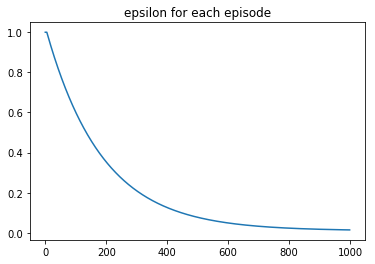

In [25]:
plt.plot(epsilon_list)
plt.title('epsilon for each episode')
plt.show()

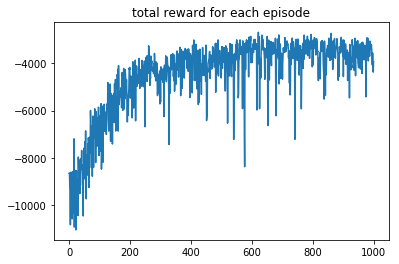

In [26]:
plt.plot(total_reward_per_episode)
plt.title('total reward for each episode')
#plt.ylim(-1000,1000)
plt.show()

In [ ]:
# test

In [5]:
# variables for graph

def length_def(detectors_ID):
    length_sum = 0
    for detector in detectors_ID:
        length = traci.lanearea.getJamLengthMeters(detector)
        length_sum += length
    return length_sum

def delay_def(detectors_ID):
    delay_sum = 0
    for detector in detectors_ID:
        speed_limit = traci.lane.getMaxSpeed(traci.lanearea.getLaneID(detector))
        delay = (speed_limit - traci.lanearea.getLastStepMeanSpeed(detector))/speed_limit
        delay_sum += delay
    return delay_sum

def waiting_def(detectors_ID):
    waiting_sum = 0
    for detector in detectors_ID:
        waiting = traci.lane.getWaitingTime(traci.lanearea.getLaneID(detector))
        waiting_sum += delay
    return waiting_sum

def halting_def(detectors_ID):
    halting_sum = 0
    for detector in detectors_ID:
        halting = traci.lanearea.getLastStepHaltingNumber(detector)
        halting_sum += halting
    return halting_sum

def co2_def(detectors_ID): # every time step
    co2_sum = 0
    for detector in detectors_ID:
        co2 = traci.lane.getCO2Emission(traci.lanearea.getLaneID(detector))
        co2_sum += co2    
    return co2_sum

def fuel_def(detectors_ID): # every time step
    fuel_sum = 0
    for detector in detectors_ID:
        fuel = traci.lane.getFuelConsumption(traci.lanearea.getLaneID(detector))
        fuel_sum += fuel    
    return fuel_sum


In [6]:
# Test 
def run_test(act, n_episodes, weights):
    sumoBinary = "C:/Program Files (x86)/DLR/Sumo/bin/sumo" # SUMO path
    if act :
        sumo_cfg = "SUMO_files/cross.sumocfg"
    else:
        sumo_cfg = "SUMO_files/cross_noRL.sumocfg"
        
    sumoCmd = [sumoBinary, "-c", sumo_cfg]
    traci.start(sumoCmd) # starts the SUMO simulation defined in sumoCmd

    TL_id = traci.trafficlight.getIDList() # list of traffic lights (just one n this case)
    total_step = 2000		# total step of eachs simulation
    detectors_ID = traci.lanearea.getIDList()
    total_episodes = n_episodes
    update_time = 10
    agent = AgentClass(0)
    agent.load(weights)
    traci.close()
    t = 0
    total_reward_per_episode = []
    total_co2_per_episode = []
    total_fuel_per_episode = []
    co2_cumulative = []
    fuel_cumulative = []
    reward_cumulative = []

    for episode in range(total_episodes):
        traci.start(sumoCmd)
        state = TL_state(detectors_ID) 
        total_reward = 0
        total_fuel = 0
        total_co2 = 0
        step = 0
        number_of_phases = 6    # TO DO: get it from traci
        done = False


        while step <= total_step:
            if act:
                action = agent.select_action(state)  # 0 or 1 (stay or change - simple control logic)
                curr_phase = traci.trafficlight.getPhase(TL_id[0])
                next_phase = (curr_phase + action) % number_of_phases
                traci.trafficlight.setPhase(TL_id[0], next_phase)

            for i in range(update_time):
                traci.simulationStep()
                step+=1 
                
                co2 = co2_def(detectors_ID)
                total_co2 += co2
                co2_cumulative.append(total_co2)

                fuel = fuel_def(detectors_ID)
                total_fuel += fuel
                fuel_cumulative.append(total_fuel)
        
            reward = TL_reward(detectors_ID)
            next_s = TL_state(detectors_ID)
            total_reward += reward
            reward_cumulative.append(total_reward)
            state = next_s

        traci.close()
        total_reward_per_episode.append(total_reward)

        total_co2_per_episode.append(total_co2)
        total_fuel_per_episode.append(total_fuel)
        
    return total_reward_per_episode,total_co2_per_episode,total_fuel_per_episode,reward_cumulative,co2_cumulative,fuel_cumulative



In [7]:
rpe,cpe,fpe,rc,cc,fc = run_test(True, 1,'model_weights_halting.h5')  # test with agent

In [8]:
rpe1,cpe1,fpe1,rc1,cc1,fc1 = run_test(False, 1,'model_weights_halting.h5')  # test without agent (fixed timings)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

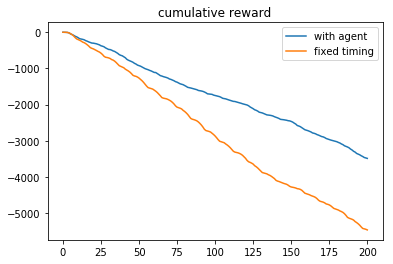

In [11]:
plt.plot(rc, label = 'with agent')
plt.plot(rc1, label = 'fixed timing')
plt.title('cumulative reward')
plt.legend()
plt.show()

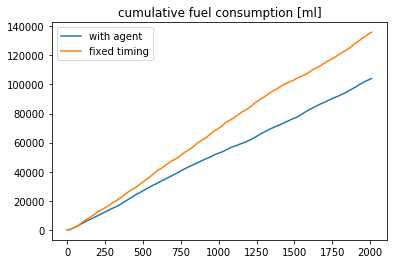

In [13]:
plt.plot(fc, label = 'with agent')
plt.plot(fc1, label = 'fixed timing')
plt.title('cumulative fuel consumption [ml]')
plt.legend()
plt.show()

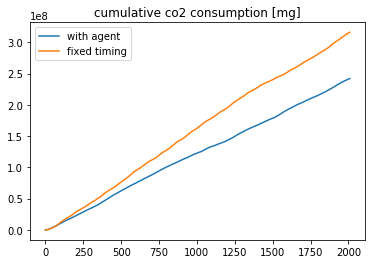

In [12]:
plt.plot(cc, label = 'with agent')
plt.plot(cc1, label = 'fixed timing')
plt.title('cumulative co2 consumption [mg]')
plt.legend()
plt.show()

In [17]:
rpe

[-3487, -3487, -3487, -3487, -3487, -3487, -3487, -3487, -3487, -3487]